In [2]:
import numpy as np
import os
from knn import libKNN
from svm import libSVM
from glob import glob
import torch

In [3]:
# base settings
def op_load_csv(path):
    f = open(path, 'r')
    content = f.readlines()
    content = [x.strip() for x in content]
    content = content[1:]
    data = [(x.split(',')[0], int(x.split(',')[1])) for x in content]
    return data

def op_load_npy(path):
    data = np.load(path)
    return data

def op_write_csv(test_files, test_pred_labels, out):
    all_out = []
    all_out.append('id,category')
    for i,each in enumerate(test_files):
        all_out.append('{},{}'.format(each[7:],int(test_pred_labels[i])))
    content = '\n'.join(all_out)
    f = open(out, 'w')
    f.writelines(content)
    f.close()

def op_merge_data(labels, prefix, concat=True):
    """merge data

    Args:
        labels (list(tuple)): labels for each file in csv
        prefix (str): where to load npy
        concat (bool, optional): if concat all data along dimension 0 into one array. Defaults to True.

    Returns:
        label_data (np.ndarray | list(np.ndarray)): labels for all frames, shape [1334*100,] if concat=True
        feats_data (np.ndarray | list(np.ndarray)): feats for all frames, shape [1334*100, 15] if concat=True

    """
    label_data = []
    feats_data = []
    for each in labels:
        npy_data = op_load_npy(os.path.join(prefix, each[0]))
        label_data.append(np.zeros(npy_data.shape[0])+each[1])
        feats_data.append(npy_data)
    if concat:
        label_data = np.concatenate(label_data)
        feats_data = np.concatenate(feats_data)
    return label_data, feats_data

def preprocess_data(label, feats, mode='norm'):
    """preprocess func

    Args:
        mode (str, optional): what you want to do. Defaults to 'norm'.

    Returns:
        label_data (np.ndarray): labels for all frames, shape [1334*100,]
        feats_data (np.ndarray): feats for all frames, shape [1334*100, 15]
    """
    if mode == 'norm':
        N = label.shape[0] if isinstance(label, np.ndarray) else len(label)*label[0].shape[0]
        label_data = label
        max_f = feats.max(axis=1)
        min_f = feats.min(axis=1)
        f_range = max_f - min_f
        feats_data = (feats - feats.min(axis=1).reshape(N,1)) / f_range.reshape(N,1)
        unkeep = np.unique(np.argwhere(np.isnan(feats_data)==True)[:,0])
        keep = np.ones(len(label_data)).astype(np.bool)
        keep[unkeep] = False
    elif mode == 'horizon_norm':
        pass
    else:
        print('error!')
        return None
    return label_data[keep], feats_data[keep], f_range, min_f

def process_test_data(feats, mode='norm'):
    if mode == 'norm':
        N = feats.shape[0]
        max_f = feats.max(axis=1)
        min_f = feats.min(axis=1)
        f_range = max_f - min_f
        feats_data = (feats - feats.min(axis=1).reshape(N,1)) / f_range.reshape(N,1)
        unkeep = np.unique(np.argwhere(np.isnan(feats_data)==True)[:,0])
        keep = np.ones(N).astype(np.bool)
        keep[unkeep] = False
    elif mode == 'horizon_norm':
        pass
    else:
        print('error!')
        return None
    return feats_data[keep]

def cal_label(labels):
    return np.argmax(np.bincount(np.array(labels).astype(np.int32)))

### process inputs for both train and test

In [4]:
train_dir = './train/'
test_dir  = './test/'
label_train = './label_train.csv'

# load labels and corresponding feats
label = op_load_csv(label_train)
labels,feats = op_merge_data(label, train_dir, concat=True)
# preprocess
train_labels, train_feats, _, _ = preprocess_data(labels, feats, mode='norm') #133400 frames, each frame has 15 channels.
test_file_names = sorted(glob(os.path.join(test_dir,"*")))
all_test_feats = []
for i in test_file_names:
    test_origin_feats = np.load(i)
    all_test_feats.append(process_test_data(test_origin_feats))

ipykernel_launcher:64: RuntimeWarning: invalid value encountered in true_divide
ipykernel_launcher:81: RuntimeWarning: invalid value encountered in true_divide


In [5]:
def test_precedure(clf,all_test_feats):
    results = []
    for test_feat in all_test_feats:
        labels = clf.predict(test_feat)
        results.append(cal_label(labels))
    return results

def calculate_recall(y_true, p_pred):
    # convert probability (y=1) to label with threshold 0.5
    y_pred = np.round(p_pred)
    diff = y_pred - y_true
    correctN = np.argwhere(diff == 0.).shape[0]
    return 'recall', correctN/len(y_true), True

def eval_preds(clf, y_true):
    pred = clf.predict(train_feats)
    diff = pred - y_true
    correctN = np.argwhere(diff == 0.).shape[0]
    print('{}'.format(correctN/len(y_true)))


In [ ]:
# classifier = libSVM(C = 1.0)
# classifier.train(train_labels, train_feats)
# classifier.eval(train_labels, train_feats)
# test_pred_labels = test_precedure(classifier, all_test_feats)
# out_name = 'svm_1.5'+'_test_results.csv'
# op_write_csv(test_file_names, test_pred_labels, out=out_name)

### lightgbm

In [5]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV

gbm = LGBMClassifier(objective='multiclass')
param_grid = {
    'learning_rate': [0.1],
    'n_estimators': range(200,400,100),
    'num_leaves':[30,31]
}
gbms = GridSearchCV(gbm, param_grid)
gbms.fit(train_feats, train_labels)
print('Best parameters found by grid search are:', gbms.best_params_)
# gbm.fit(train_feats, train_labels)
# eval_preds(gbm, train_labels)

Best parameters found by grid search are: {'learning_rate': 0.1, 'n_estimators': 300, 'num_leaves': 31}


In [12]:
bst_gbm = LGBMClassifier(objective='multiclass', num_leaves=31, learning_rate=0.11, n_estimators=700)
bst_gbm.fit(train_feats, train_labels)
eval_preds(bst_gbm, train_labels)
test_pred_labels = test_precedure(bst_gbm, all_test_feats)
out_name = 'gbm_0.11_700'+'_test_results.csv'
op_write_csv(test_file_names, test_pred_labels, out=out_name)

0.9989525639576504


### xgboost

In [17]:
from xgboost import XGBClassifier

xgb1 = XGBClassifier(learning_rate =0.1,
                    max_depth=5,
                    min_child_weight=1,
                    n_estimators=100,
                    gamma=0,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    objective= 'binary:logistic',
                    nthread=16,
                    use_label_encoder=False,
                    seed=27)

# param_grid = {
#     "n_estimators":range(100,300,100)
# }
# xgbs = GridSearchCV(xgb1, param_grid)
xgb1.fit(train_feats, train_labels)
eval_preds(xgb1, train_labels)

[17:16:31] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.798138728759278


In [ ]:
xgb1 = XGBClassifier(learning_rate =0.1,
                    n_estimators=1000,
                    max_depth=5,
                    min_child_weight=1,
                    gamma=0,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    objective= 'binary:logistic',
                    nthread=4,
                    scale_pos_weight=1,
                    seed=27)

param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
xgbs = GridSearchCV(xgb1, param_test1)
xgbs.fit(train_feats, train_labels)
print('Best parameters found by grid search are:', xgbs.best_params_)

In [ ]:
xgb1 = XGBClassifier(learning_rate =0.1,
                    n_estimators=1000,
                    max_depth=5,
                    min_child_weight=1,
                    gamma=0,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    objective= 'binary:logistic',
                    nthread=4,
                    scale_pos_weight=1,
                    seed=27)

param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
xgbs = GridSearchCV(xgb1, param_test3)
xgbs.fit(train_feats, train_labels)
print('Best parameters found by grid search are:', xgbs.best_params_)

In [ ]:
xgb1 = XGBClassifier(learning_rate =0.1,
                    n_estimators=1000,
                    max_depth=5,
                    min_child_weight=1,
                    gamma=0,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    objective= 'binary:logistic',
                    nthread=4,
                    scale_pos_weight=1,
                    seed=27)

param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
xgbs = GridSearchCV(xgb1, param_test4)
xgbs.fit(train_feats, train_labels)
print('Best parameters found by grid search are:', xgbs.best_params_)

In [ ]:
xgb1 = XGBClassifier(learning_rate =0.1,
                    n_estimators=1000,
                    max_depth=5,
                    min_child_weight=1,
                    gamma=0,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    objective= 'binary:logistic',
                    nthread=4,
                    scale_pos_weight=1,
                    seed=27)

param_test5 = {
 'subsample':[i/100.0 for i in range(75,90,5)],
 'colsample_bytree':[i/100.0 for i in range(75,90,5)]
}
xgbs = GridSearchCV(xgb1, param_test5)
xgbs.fit(train_feats, train_labels)
print('Best parameters found by grid search are:', xgbs.best_params_)

In [ ]:
xgb1 = XGBClassifier(learning_rate =0.1,
                    n_estimators=1000,
                    max_depth=5,
                    min_child_weight=1,
                    gamma=0,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    objective= 'binary:logistic',
                    nthread=4,
                    scale_pos_weight=1,
                    seed=27)

param_test6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
xgbs = GridSearchCV(xgb1, param_test6)
xgbs.fit(train_feats, train_labels)
print('Best parameters found by grid search are:', xgbs.best_params_)

In [ ]:
## get the final xgboost model
clf = XGBClassifier(learning_rate =0.1,
                n_estimators=1000,
                max_depth=5,
                min_child_weight=1,
                gamma=0,
                subsample=0.8,
                colsample_bytree=0.8,
                objective= 'binary:logistic',
                nthread=4,
                scale_pos_weight=1,
                seed=27)
clf.fit(train_feats, train_labels)
eval_preds(clf, train_labels)
test_pred_labels = test_precedure(clf, all_test_feats)
out_name = 'xgb'+'_test_results.csv'
op_write_csv(test_file_names, test_pred_labels, out=out_name)

### LDA

In [36]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
clf = LDA(n_components=5)
clf.fit(train_feats, train_labels)
eval_preds(clf, train_labels)
test_pred_labels = test_precedure(clf, all_test_feats)
out_name = 'LDA'+'_test_results.csv'
op_write_csv(test_file_names, test_pred_labels, out=out_name)

LinAlgError: SVD did not converge

In [18]:
import pandas as pd 
a = pd.read_csv('label_train.csv')
a

,id,category
0,0535.npy,0
1,0274.npy,0
2,0949.npy,0
3,1301.npy,0
4,0886.npy,0
...,...,...
1329,0961.npy,19
1330,1015.npy,19
1331,1672.npy,19
1332,1129.npy,19


In [27]:
vis = []
for i in range(20):
    vis.append(np.where(np.asarray(a['category'])==i)[0].shape[0])

(60, 70)

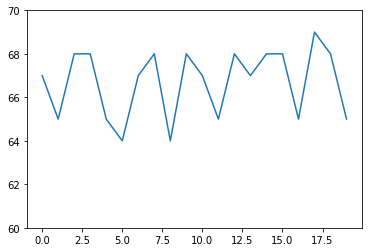

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(range(0,20),vis)
plt.ylim(60,70)

### Random Forest

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample

### use resample BootStrape
tmp = []
for i in range(100):
    X, y = resample(train_feats, train_labels,random_state=0)
    clf = RandomForestClassifier(oob_score=True, random_state=10,n_jobs=-1)
    clf.fit(X, y)
    tmp.append(clf)
# mean_parameters = mean(tmp)
# eval_preds(clf, train_labels)
# test_pred_labels = test_precedure(clf, all_test_feats)
# out_name = 'RF'+'_test_results.csv'
# op_write_csv(test_file_names, test_pred_labels, out=out_name)

KeyboardInterrupt: 

### verify data

In [2]:
import numpy as np
data = np.load("train/1542.npy")
data

array([[-0.        , -0.        , -0.        , ..., -0.        ,
        -0.        , -0.        ],
       [-0.        , -0.        , -0.        , ..., -0.        ,
        -0.        , -0.        ],
       [-0.06687263, -0.9555    ,  0.73019238, ...,  1.53544603,
         0.70008557, -0.27196248],
       ...,
       [-0.09825516, -0.63070382,  1.30459921, ...,  0.92795876,
        -0.03304696, -0.24504587],
       [-0.        , -0.        , -0.        , ..., -0.        ,
        -0.        , -0.        ],
       [-0.        , -0.        , -0.        , ..., -0.        ,
        -0.        , -0.        ]])